In [75]:
import sys
from pathlib import Path

# Add the project root to sys.path
project_root = Path().resolve().parent  # Adjust as needed to point to the root folder
sys.path.append(str(project_root))

print(sys.path)  # Check if the path is added


['C:\\Program Files\\Python310\\python310.zip', 'C:\\Program Files\\Python310\\DLLs', 'C:\\Program Files\\Python310\\lib', 'C:\\Program Files\\Python310', 'g:\\Work\\DS\\neural-net-from-scratch\\.venv', '', 'g:\\Work\\DS\\neural-net-from-scratch\\.venv\\lib\\site-packages', 'g:\\Work\\DS\\neural-net-from-scratch\\.venv\\lib\\site-packages\\win32', 'g:\\Work\\DS\\neural-net-from-scratch\\.venv\\lib\\site-packages\\win32\\lib', 'g:\\Work\\DS\\neural-net-from-scratch\\.venv\\lib\\site-packages\\Pythonwin', 'G:\\Work\\DS\\neural-net-from-scratch', 'G:\\Work\\DS\\neural-net-from-scratch', 'G:\\Work\\DS\\neural-net-from-scratch', 'G:\\Work\\DS\\neural-net-from-scratch', 'G:\\Work\\DS\\neural-net-from-scratch']


In [76]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt
from os.path  import join
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#
# Set file paths based on added MNIST Datasets
#
input_path = '../data'
data = np.array(pd.read_csv(join(input_path, 'train.csv')))
print(data.shape)

train_set, dev_set = train_test_split(data, test_size=0.2, random_state=42)
X_train = train_set[:1000, 1:data.shape[1]]
y_train = train_set[:1000, 0:1]
X_dev = dev_set[:, 1:data.shape[1]]
y_dev = dev_set[:, 0:1]

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1



(42000, 785)


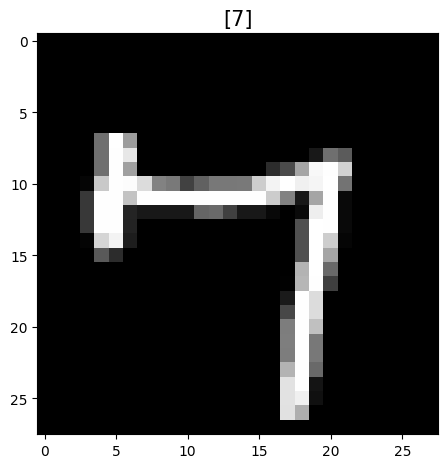

In [77]:
show_images([X_train[7].reshape(28, 28)], [y_train[7]])

In [92]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

digit_encoder = OneHotEncoder()
Y_true = digit_encoder.fit_transform(y_train).toarray().T

scaler = MinMaxScaler()
A0 = scaler.fit_transform(X_train)
A0 = A0.T

### Neural Network

In [107]:
def sigmoid(x):
    return np.exp(x)/(1 + np.exp(x))

def relu(X):
     return np.maximum(0 ,X)

def leaky_relu(X, alpha=0.01):
    return np.where(X > 0, X, alpha * X)

# Derivative for backpropagation
def derivative_leaky_relu(X, alpha=0.01):
    return np.where(X > 0, 1, alpha)


def softmax(X):
    # Subtract the max value for numerical stability
    X_stable = X - np.max(X, axis=0, keepdims=True)
    exp_X = np.exp(X_stable)
    return exp_X / np.sum(exp_X, axis=0, keepdims=True)


def init_params():
    W1 = np.random.randn(28, 784)
    b1 = np.random.rand(28, 1)
    W2 = np.random.randn(28, 28)
    b2 = np.random.rand(28, 1)
    Wy = np.random.randn(10, 28)
    return W1, b1, W2, b2, Wy

def forward_prop(A0, W1,b1,W2,b2,Wy):
    Z1 = W1.dot(A0) + b1
    A1 = leaky_relu(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = leaky_relu(Z2)
    Zy = Wy.dot(A2)
    Y = softmax(Zy)
    return Y, A2, Z2, A1, Z1

def back_prop(Y, Y_true, Wy, A2, Z2, W2, A1, Z1, A0, m):
    dC_dZy = Y - Y_true
    dZy_dWy = A2.T # Transpose for matching dimension
    #Ouput Layer
    dC_dWy = np.dot(dC_dZy, dZy_dWy) / m

    dC_dZ2 = np.dot(Wy.T, dC_dZy) *  derivative_leaky_relu(Z2)
    #2nd Hidden Layer
    dC_dW2 = np.dot(dC_dZ2, A1.T) / m
    dC_db2 = np.sum(dC_dZ2, axis=1, keepdims=True) / m

    dC_dZ1 = np.dot(W2.T, dC_dZ2) * derivative_leaky_relu(Z1)
    #1st Hidden Layer
    dC_dW1 = np.dot(dC_dZ1, A0.T) / m
    dC_db1 = np.sum(dC_dZ1, axis=1, keepdims=True) / m 

    return dC_dW1, dC_db1, dC_dW2, dC_db2, dC_dWy

def gradient_descent(alpha, W1, b1, W2, b2, Wy, dC_dW1, dC_db1, dC_dW2, dC_db2, dC_dWy):
    W1 = W1 - alpha * dC_dW1
    b1 = b1 - alpha * dC_db1
    W2 = W2 - alpha * dC_dW2
    b2 = b2 - alpha * dC_db2
    Wy = Wy - alpha * dC_dWy
    return W1, b1, W2, b2, Wy

def predict(test_data, W1, b1, W2, b2, Wy):
        Y_pred, A2, Z2, A1, Z1 = forward_prop(test_data, W1, b1, W2, b2, Wy)
        return Y_pred

def one_hot_to_digit(predictions):
    # Use argmax to find the index of the maximum value in each column (sample)
    digit_labels = np.argmax(predictions, axis=0)
    return digit_labels

In [108]:
n = Y_true.shape[0]
m = Y_true.shape[1]
W1,b1,W2,b2,Wy = init_params()
alpha = 0.1 #learning rate

for iteration in range(10000):
    Y, A2, Z2, A1, Z1 = forward_prop(A0, W1, b1, W2, b2, Wy)

    dC_dW1, dC_db1, dC_dW2, dC_db2, dC_dWy = back_prop(Y, Y_true, Wy, A2, Z2, W2, A1, Z1, A0, m)

    W1, b1, W2, b2, Wy = gradient_descent(alpha, W1, b1, W2, b2, Wy, dC_dW1, dC_db1, dC_dW2, dC_db2, dC_dWy)

    if iteration % 1000 == 0:
        dead_neurons = np.mean(A1 == 0) * 100
        print(f"Percentage of dead neurons in A1: {dead_neurons:.2f}%")

        Y_pred = predict(A0, W1, b1, W2, b2, Wy)
        preds = one_hot_to_digit(Y_pred)
        print(f"Accuracy for {iteration} iteration: {accuracy_score(y_train, preds) * 100}%")


Percentage of dead neurons in A1: 0.00%
Accuracy for 0 iteration: 13.200000000000001%
Percentage of dead neurons in A1: 0.00%
Accuracy for 1000 iteration: 81.2%
Percentage of dead neurons in A1: 0.00%
Accuracy for 2000 iteration: 89.5%
Percentage of dead neurons in A1: 0.00%
Accuracy for 3000 iteration: 93.10000000000001%
Percentage of dead neurons in A1: 0.00%
Accuracy for 4000 iteration: 95.0%
Percentage of dead neurons in A1: 0.00%
Accuracy for 5000 iteration: 96.5%
Percentage of dead neurons in A1: 0.00%
Accuracy for 6000 iteration: 97.39999999999999%
Percentage of dead neurons in A1: 0.00%
Accuracy for 7000 iteration: 98.5%
Percentage of dead neurons in A1: 0.00%
Accuracy for 8000 iteration: 98.9%
Percentage of dead neurons in A1: 0.00%
Accuracy for 9000 iteration: 99.4%


In [109]:
x_dev_scaled = scaler.transform(X_dev)
x_dev_scaled = x_dev_scaled.T
Y_pred = predict(x_dev_scaled, W1, b1, W2, b2, Wy)
Y_pred = one_hot_to_digit(Y_pred)

print(f"Accuracy: {accuracy_score(y_dev, Y_pred) * 100}%")

Accuracy: 73.88095238095238%


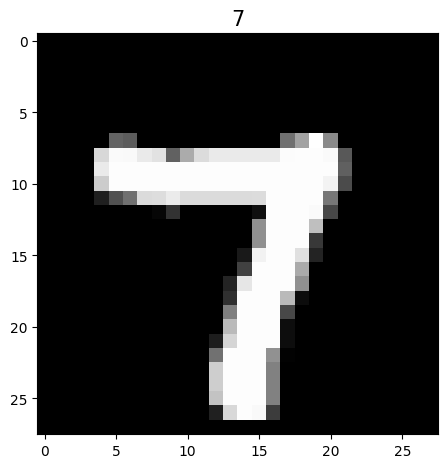

In [111]:
show_images([X_dev[8].reshape(28, 28)], [Y_pred[8]])